# Script to predict glacier-wide mass balance from ML model

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde
from pyproj import Proj, transform

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from plotting_functions import plot_prediction_per_fold
from plotting_functions import plot_prediction
from plotting_functions import plot_gsearch_results

from model_classes import CustomXGBRegressor
from sklearn.utils.validation import check_is_fitted



## Helper functions

In [2]:
# Get modelled mass balance from xarray Dataset based on 
# dataframe of point mass balances

def get_modelled_mb(df, ds, type):
    """
    df : pd.DataFrame of point mb (mass balance)
    ds : xr.DataSet of modelled mass balance
    type : str, variable in ds; 'mb_annual', 'mb_summer', or 'mb_winter'
    """
    
    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        # Use the attributes of namedtuple
        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        # Check if the current_year_dt is in the 'time' coordinate of the dataset
        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            # Check if current_id exists in the 'ID' coordinate of the dataset
            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:
            # If modelled mb is not available for the current year, use nan
            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


In [3]:
# Get true values (means) and predicted values (aggregates)

def get_ytrue_y_pred_agg(y_true, y_pred, X):
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [4]:
def get_ytrue_y_pred_agg_season(y_true, y_pred, X, months=12):

    # Get values for the given season
    mask = X[:, -2] == months  
    X = X[mask] 
    
    # Extract the metadata
    metadata = X[:, -3:]  # Assuming last three columns are the metadata
    unique_ids = np.unique(metadata[:, 0]) # Assuming ID is the first column
    y_pred_agg_all = []
    y_true_mean_all = []
    
    # Loop over each unique ID to calculate MSE
    for uid in unique_ids:
        # Indexes for the current ID
        indexes = metadata[:, 0] == uid
        # Aggregate y_pred for the current ID
        y_pred_agg = np.sum(y_pred[indexes])
        y_pred_agg_all.append(y_pred_agg)
        # True value is the mean of true values for the group
        y_true_mean = np.mean(y_true[indexes])
        y_true_mean_all.append(y_true_mean)

    y_pred_agg_all_arr = np.array(y_pred_agg_all)
    y_true_mean_all_arr = np.array(y_true_mean_all)
    
    return y_true_mean_all_arr, y_pred_agg_all_arr

In [5]:
def get_prediction_per_season_test(X_test, y_test, best_model, months=12):

    y_pred = best_model.predict(X_test)

    indices = np.argwhere((X_test[:,-2] == months))[:,0]
    y_test_crop = y_test[indices]
    y_pred_crop = y_pred[indices]

    return y_test_crop, y_pred_crop

## Prepare topographical features for glacier

In [6]:
rgiid = 'RGI60-08.02643'
filepath_topo = 'Data/oggm_data/per_glacier/train/'+rgiid+'/'
filename_grid = 'gridded_data.nc'
glacier_id = 3129

In [7]:
with xr.open_dataset(filepath_topo + filename_grid) as ds_out:
    ds = ds_out

In [8]:
ds

<xarray.Dataset>
Dimensions:                  (x: 115, y: 97)
Coordinates:
  * x                        (x) float32 -2.407e+03 -2.369e+03 ... 1.925e+03
  * y                        (y) float32 6.661e+06 6.661e+06 ... 6.657e+06
Data variables: (12/20)
    topo                     (y, x) float32 ...
    topo_smoothed            (y, x) float32 ...
    topo_valid_mask          (y, x) int8 ...
    glacier_mask             (y, x) int8 ...
    glacier_ext              (y, x) int8 ...
    consensus_ice_thickness  (y, x) float32 ...
    ...                       ...
    aspect                   (y, x) float32 ...
    slope_factor             (y, x) float32 ...
    dis_from_border          (y, x) float32 ...
    catchment_area           (y, x) float32 ...
    lin_mb_above_z           (y, x) float32 ...
    oggm_mb_above_z          (y, x) float32 ...
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=6.427 +k=0.9996 +x_0=0 +y_0=0...
    max_h_dem:      1654.0
    min_h_dem:      790.0
    max_h_glacier:  1654.0
    min_h_glacier:  1231.0

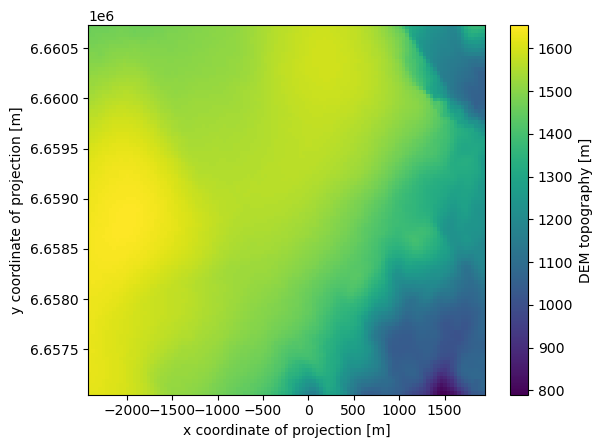

In [9]:
ds.topo.plot()

In [10]:
# Get glacier mask (ones) as numpy array
#mask = ds.glacier_mask.values

# Get glacier elevation as numpy array
#elev = ds.topo.values 

# Get array of elevation in glacier grid cells
#masked_elev = elev * mask

# Get vector of elevation in glacier grid cells
#masked_elev_vec = masked_elev[masked_elev>0]

In [11]:
# Assuming ds is your xarray dataset and 'glacier_mask' and 'topo' are the variable names
glacier_mask = ds['glacier_mask'].values  # Retrieve the glacier mask as a numpy array
elev = ds['topo'].values  # Retrieve the elevation data as a numpy array
slope = ds['slope'].values
aspect = ds['aspect'].values

# Ensure the mask is interpreted correctly as a boolean array
glacier_mask_bool = glacier_mask == 1

# Apply the mask to retrieve only elevation values of glacier cells
masked_elev = elev[glacier_mask_bool]
masked_slope = slope[glacier_mask_bool]
masked_aspect = aspect[glacier_mask_bool]

# Get the indices where the glacier mask is True (indicating glacier cells)
glacier_indices = np.where(glacier_mask_bool)

# Assuming the coordinate variables are named 'x' and 'y' in your dataset
x_coords = ds['x'].values
y_coords = ds['y'].values

# Retrieve the x and y values using the glacier indices
glacier_x_vals = x_coords[glacier_indices[1]]
glacier_y_vals = y_coords[glacier_indices[0]]

# Print the resulting vectors
print("Glacier x-coordinates:", glacier_x_vals)
print("Glacier y-coordinates:", glacier_y_vals)
print("Glacier elevations:", masked_elev)
print("Glacier slope:", masked_slope)
print("Glacier aspect:", masked_aspect)


Glacier x-coordinates: [214.67305 214.67305 252.67305 ... 214.67305 366.67307 176.67305]
Glacier y-coordinates: [6660332. 6660294. 6660294. ... 6657444. 6657444. 6657406.]
Glacier elevations: [1592. 1592. 1593. ... 1336. 1284. 1350.]
Glacier slope: [0.00608832 0.0103517  0.01584816 ... 0.3105932  0.34008485 0.2938187 ]
Glacier aspect: [2.9625652 3.122973  2.2697387 ... 1.8111074 1.9943147 1.9120138]


In [12]:
# Define the source projection from the dataset's coordinate system
proj_string = ds.pyproj_srs
source_proj = Proj(proj_string)

# Define the target projection (WGS84)
target_proj = Proj(proj='latlong', datum='WGS84')

# Convert glacier coordinates to latitude and longitude
lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)

# Print or return the resulting latitude and longitude vectors
print("Latitude coordinates:", lat)
print("Longitude coordinates:", lon)

Latitude coordinates: [60.08010174 60.07976054 60.07976052 ... 60.0541699  60.05416979
 60.05382871]
Longitude coordinates: [6.43085806 6.43085802 6.43154094 ... 6.43085503 6.4335846  6.43017261]


C:\Users\kasj\AppData\Local\Temp\ipykernel_22212\4255833983.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(source_proj, target_proj, glacier_x_vals, glacier_y_vals)


In [13]:
# Create a DataFrame
data = {
    'RGIID': [rgiid] * len(masked_elev),
    'BREID': [glacier_id] * len(masked_elev),
    'altitude': masked_elev,
    'lat': lat,
    'lon': lon,
    'aspect': masked_aspect,
    'slope': masked_slope
}

df = pd.DataFrame(data, columns=['RGIID', 'BREID', 'altitude', 'lat', 'lon', 'aspect', 'slope'])


In [14]:
df

,RGIID,BREID,altitude,lat,lon,aspect,slope
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956
...,...,...,...,...,...,...,...
2824,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480
2825,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677
2826,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593
2827,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085


In [15]:
# Add years
years = np.arange(1960, 2022)
num_years = len(years)
num_rows_per_year = len(df)

# Repeat the DataFrame num_years times
df = pd.concat([df] * num_years, ignore_index=True)

# Create a 'year' column that has num_rows_per_year instances of year
year_column = np.repeat(years, num_rows_per_year)

# Add the 'year' column to the DataFrame
df['year'] = year_column

In [16]:
df

,RGIID,BREID,altitude,lat,lon,aspect,slope,year
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088,1960
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352,1960
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848,1960
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217,1960
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956,1960
...,...,...,...,...,...,...,...,...
175393,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480,2021
175394,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677,2021
175395,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593,2021
175396,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085,2021


## Add climate features for glacier

In [17]:
filepath_climate = 'Data/ERA5-Land_mon_avg_1950_2022_Norway/'
filename_climate = 'data.nc'

In [18]:
# Load climate cataset
with xr.open_dataset(filepath_climate + filename_climate) as ds:
    ds_climate = ds.load()

# Reduce expver dimension
ds_climate = ds_climate.reduce(np.nansum, 'expver')

In [19]:
# ds_climate contains 14 variables:
# ['u10','v10','t2m','fal','asn','sde','sd','slhf','ssr','str','sshf','ssrd','strd','tp']
# u10: 10m u-component of wind, 
# v10: 10m v-component of wind, 
# t2m: 2m temperature, 
# fal: Forecast albedo, 
# asn: Snow albedo, 
# sde: Snow depth, 
# sd: Snow depth water equivalent, 
# slhf: Surface latent heat
# ssr: Surface net solar radiation, 
# str: Surface net thermal radiation,
# sshf: Surface sensible heat flux, 
# ssrd: Surface solar radiation downwards, 
# strd: Surface thermal radiation downwards, 
# tp: Total precipitation

ds_climate

<xarray.Dataset>
Dimensions:    (longitude: 271, latitude: 141, time: 880)
Coordinates:
  * longitude  (longitude) float32 4.0 4.1 4.2 4.3 4.4 ... 30.7 30.8 30.9 31.0
  * latitude   (latitude) float32 71.5 71.4 71.3 71.2 ... 57.8 57.7 57.6 57.5
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2023-04-01
Data variables: (12/14)
    u10        (time, latitude, longitude) float32 0.0 0.0 ... -0.6157 -0.6011
    v10        (time, latitude, longitude) float32 0.0 0.0 ... -0.3065 -0.2986
    t2m        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 280.4 280.5
    fal        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.2273 0.2009
    asn        (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.644 0.6407
    sde        (time, latitude, longitude) float32 0.0 0.0 ... 0.06174 0.05579
    ...         ...
    ssr        (time, latitude, longitude) float32 0.0 0.0 ... 7.523e+06
    str        (time, latitude, longitude) float32 0.0 0.0 ... -2.835e+06
    sshf       (time, latitude, longitude) float32 0.0 0.0 ... -1.193e+06
    ssrd       (time, latitude, longitude) float32 0.0 0.0 ... 9.21e+06
    strd       (time, latitude, longitude) float32 0.0 0.0 ... 1.277e+07
    tp         (time, latitude, longitude) float32 0.0 0.0 ... 0.0003496

In [20]:
# Get latitude and longitude of Norway climate data
lat_clim = ds_climate.latitude
lon_clim = ds_climate.longitude
    
#%% Load geopotential height
with xr.open_dataset(filepath_climate + 'geo.nc') as ds_geo:
    ds_geopotential = ds_geo.load()
    
# Convert geopotential height to geometric height and add to dataset
R_earth = 6367.47 * 10e3 #m (Grib1 radius)
g = 9.81 # m/s2

ds_geopot_metric = ds_geopotential.assign(altitude_climate = lambda ds_geopotential: 
                                          R_earth * ((ds_geopotential.z/g)/(R_earth - (ds_geopotential.z/g))))

# Crop geometric height to grid of climate data
ds_geopot_metric_crop = ds_geopot_metric.sel(longitude = lon_clim, latitude = lat_clim)

In [21]:
# Selection of climate variables
#var_names = list(ds_climate.keys())
var_names = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
month_names = ['_oct','_nov','_dec','_jan','_feb','_mar','_apr','_may','_jun','_jul','_aug','_sep']

# Combine variables and months
month_vars = []
for var in var_names:
    month_vars.extend([f'{var}{mm:02}' for mm in month_names])

In [22]:
# Empty array to store values.
climate_all = np.empty((len(df.index),len(month_vars)))
climate_all.fill(np.nan)

altitude_all = np.empty((len(df.index),1))
altitude_all.fill(np.nan)


In [23]:
# Get data for each point in dataframe

total_iterations = len(df)

for i in df.index:
    
    # Get location and year for point measurement
    lat_stake = df.loc[i,'lat'].round(2)#.values.round(2)
    lon_stake = df.loc[i,'lon'].round(2)#.values.round(2)
    #date_stake = pd.to_datetime(point_data.loc[i,'dt_curr_year_max_date'], format="%d.%m.%Y %H:%M")
    year_stake = df.loc[i,'year']
    
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                               longitude=lon_stake,
                               time=pd.date_range(str(year_stake-1) + '-09-01',
                                                  str(year_stake) + '-09-01',
                                                  freq='M'),
                               method = "nearest")
    
    # Convert dataarray to dataframe.
    d_climate = p_climate.to_dataframe()
    
    # Drop latitude and longitude columns from dataframe.
    d_climate.drop(columns=['latitude','longitude'],inplace=True)
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method = "nearest")
    
    #d_climate['altitude_climate'] = p_alt.altitude_climate.values[0]
    
    # Flatten dataframe along columns such that each column (oct-sept)
    # follows each other in the flattened array
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Store in array.
    climate_all[i,:] = a_climate
    altitude_all[i,:] = p_alt.altitude_climate.values[0]

    # Print progress every 5000 iterations
    if i % 5000 == 0:
        print(f'Iteration {i} of {total_iterations}')


Iteration 0 of 175398
Iteration 5000 of 175398
Iteration 10000 of 175398
Iteration 15000 of 175398
Iteration 20000 of 175398
Iteration 25000 of 175398
Iteration 30000 of 175398
Iteration 35000 of 175398
Iteration 40000 of 175398
Iteration 45000 of 175398
Iteration 50000 of 175398
Iteration 55000 of 175398
Iteration 60000 of 175398
Iteration 65000 of 175398
Iteration 70000 of 175398
Iteration 75000 of 175398
Iteration 80000 of 175398
Iteration 85000 of 175398
Iteration 90000 of 175398
Iteration 95000 of 175398
Iteration 100000 of 175398
Iteration 105000 of 175398
Iteration 110000 of 175398
Iteration 115000 of 175398
Iteration 120000 of 175398
Iteration 125000 of 175398
Iteration 130000 of 175398
Iteration 135000 of 175398
Iteration 140000 of 175398
Iteration 145000 of 175398
Iteration 150000 of 175398
Iteration 155000 of 175398
Iteration 160000 of 175398
Iteration 165000 of 175398
Iteration 170000 of 175398
Iteration 175000 of 175398


In [ ]:
# Efficient version?

from joblib import Parallel, delayed

# Assuming ds_climate and ds_geopot_metric_crop are xarray Datasets
# Predefine the time selection range once
years_unique = df['year'].unique()
time_selector = {
    year: pd.date_range(start=f"{year-1}-09-01", end=f"{year}-09-01", freq='M')
    for year in years_unique
}

# Convert latitude and longitude to pandas index
lat_stake_arr = df['lat'].round(2).to_numpy()
lon_stake_arr = df['lon'].round(2).to_numpy()
year_stake_arr = df['year'].to_numpy()

# Resultant arrays
climate_all = np.zeros((len(df), len(var_names) * 12))
altitude_all = np.zeros((len(df), 1))

def process_point(index, lat_stake, lon_stake, year_stake, ds_climate, ds_geopot_metric_crop, time_selector):
    # Select data from climate data
    p_climate = ds_climate[var_names].sel(latitude=lat_stake,
                                          longitude=lon_stake,
                                          time=time_selector[year_stake],
                                          method="nearest")
    
    # Convert DataArray to DataFrame, removing latitude/longitude
    d_climate = p_climate.to_dataframe().reset_index(drop=True).drop(['latitude', 'longitude'], axis=1, errors='ignore')
    a_climate = d_climate.to_numpy().flatten(order='F')
    
    # Select altitude of climate data for given point
    p_alt = ds_geopot_metric_crop.sel(latitude=lat_stake,
                                      longitude=lon_stake,
                                      method="nearest").values
    altitude = p_alt[0] if p_alt.size > 0 else np.nan
    
    # Return as tuple
    return index, a_climate, altitude

# Process points in parallel
results = Parallel(n_jobs=-1)(
    delayed(process_point)(index, lat_stake, lon_stake, year_stake, ds_climate, ds_geopot_metric_crop, time_selector)
    for index, lat_stake, lon_stake, year_stake in zip(df.index, lat_stake_arr, lon_stake_arr, year_stake_arr)
)

# Update results into the arrays
for index, a_climate, altitude in results:
    climate_all[index, :] = a_climate
    altitude_all[index, 0] = altitude

print("Processing completed")


In [24]:
# Make pandas dataframe from array with column names from month_vars
df_climate = pd.DataFrame(data = climate_all, columns = month_vars)
df_altitude = pd.DataFrame(data = altitude_all, columns = ['altitude_climate'])

In [25]:
# Concatenate dataframes
df_w_climate = pd.concat([df, df_climate, df_altitude], axis=1)#.reindex(point_data.index)

In [26]:
df_w_climate

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175393,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175394,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175395,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175396,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212


In [27]:
#df_w_climate['RGIID']=['RGI60-08.01258'] * len(df_w_climate)

In [28]:
# Save dataframe
#filepath_save = 'Data/'
#filename_save = 'features_'+df_w_climate.RGIID.unique()[0][-5:]+'.csv'
#df_w_climate.to_parquet(filepath_save + filename_save)

In [29]:
# Save dataframe
filepath_save = 'Data/glacier_predictions/'
filename_save = 'features_'+df_w_climate.RGIID.unique()[0][-5:]+'.csv'
df_w_climate.to_csv(filepath_save + filename_save, index=False) 

## Load ML-model

In [6]:
# Model trained on cluster using up to 0.2 for learning rate. 
# Learning rate [0.01, 0.1, 0.2]
# Max depth [2, 4, 6]
# n_estimators [50, 100, 200, 300]
#with open('Training_cluster/2024-07-10_20-37-03/custom_loss_cv_grid.pkl', 'rb') as f:
#    clf_loaded = pickle.load(f)

# Model trained on cluster using extended grid search (after implementing custom loss funciton performance improvement)
# param_ranges = {'max_depth': [4, 5, 6, 7, 8], # Depth of tree
#                'n_estimators': [200, 300, 400, 500, 600, 700], # Number of trees (too many = overfitting, too few = underfitting)
#                'learning_rate': [0.1, 0.15, 0.2, 0.25], #[0,1]
with open('Training_cluster/2024-08-19_09-12-34/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_


In [7]:
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=10, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=500, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x000001C11071CE50>, ...)

## Load dataframe

In [30]:
# Load dataframe of glacier-wide mass balances
filepath_gw_mb = 'Data/NVE_gw_mb/'
filename_gw_mb = 'massbalance_gw_Norway.csv'
df_mb = pd.read_csv(filepath_gw_mb + filename_gw_mb, sep=';')

In [31]:
df_mb

,Year,RGIID,BREID,DateMinPrevYear,DateMax,DateMin,Area,Bw,Bs,Ba,Bcalv
0,1978,NaN,26,NaN,01.05.1978,01.10.1978,2.730,2.30,-2.40,-0.10,NaN
1,1979,NaN,26,01.10.1978,01.05.1979,NaN,2.730,2.10,NaN,NaN,NaN
2,1989,RGI60-08.01258,54,NaN,24.05.1989,19.10.1989,3.621,2.38,-2.98,-0.60,NaN
3,1990,RGI60-08.01258,54,19.10.1989,24.05.1990,05.09.1990,3.621,2.60,-2.98,-0.38,NaN
4,1991,RGI60-08.01258,54,05.09.1990,14.05.1991,04.10.1991,3.621,2.25,-2.29,-0.04,NaN
...,...,...,...,...,...,...,...,...,...,...,...
759,2013,RGI60-08.02969,3141,12.10.2012,29.05.2013,24.09.2013,22.541,2.49,-3.29,-0.80,NaN
760,2014,RGI60-08.02969,3141,24.09.2013,24.04.2014,14.10.2014,22.541,2.94,-3.68,-0.74,NaN
761,2015,RGI60-08.02969,3141,14.10.2014,22.04.2015,14.10.2015,22.541,2.90,-1.54,1.36,NaN
762,2016,RGI60-08.02969,3141,14.10.2015,28.04.2016,06.10.2016,22.539,2.92,-2.85,0.07,NaN


In [31]:
# Load dataframe of features
rgiid = 'RGI60-08.02643'
filepath_glacier_data = 'Data/glacier_predictions/'
filename_glacier_data = 'features_'+rgiid[-5:]+'.csv'
df_glacier = pd.read_csv(filepath_glacier_data + filename_glacier_data)#, sep=';')\n",

# Set prediction specifications
pred_type = 'winter'
pred_range = np.arange(1962, 2020)

# Get breid from dataframe


In [32]:
df_glacier

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.02643,3129,1592.0,60.080102,6.430858,2.962565,0.006088,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
1,RGI60-08.02643,3129,1592.0,60.079761,6.430858,3.122973,0.010352,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
2,RGI60-08.02643,3129,1593.0,60.079761,6.431541,2.269739,0.015848,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
3,RGI60-08.02643,3129,1592.0,60.079760,6.432224,1.958412,0.026217,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
4,RGI60-08.02643,3129,1592.0,60.079419,6.430858,3.103738,0.015956,1960,275.879578,270.000031,...,0.002812,0.002709,0.001239,0.005917,0.001906,0.005248,0.006933,0.006172,0.003147,994.833212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175393,RGI60-08.02643,3129,1368.0,60.054170,6.429490,1.908019,0.285480,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175394,RGI60-08.02643,3129,1355.0,60.054170,6.430173,1.835035,0.302677,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175395,RGI60-08.02643,3129,1336.0,60.054170,6.430855,1.811107,0.310593,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212
175396,RGI60-08.02643,3129,1284.0,60.054170,6.433585,1.994315,0.340085,2021,275.761902,273.121613,...,0.003458,0.005320,0.008361,0.003897,0.002201,0.004765,0.006029,0.002450,0.005384,994.833212


In [10]:
# Crop dataframe to prediction range
df_glacier_crop = df_glacier[df_glacier.year.isin(pred_range)]

# Add column with n_months
if pred_type == 'winter':
    df_glacier_crop['n_months'] = 7
elif pred_type == 'summer':
    df_glacier_crop['n_months'] = 5
elif pred_type == 'annual':
    df_glacier_crop['n_months'] = 12


C:\Users\kasj\AppData\Local\Temp\ipykernel_17228\1808666777.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glacier_crop['n_months'] = 7


In [11]:
df_glacier_crop

,RGIID,BREID,altitude,lat,lon,aspect,slope,year,t2m_oct,t2m_nov,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
6834,RGI60-08.01286,2478,1592.4271,61.839195,7.327753,2.220334,0.250166,1962,272.630463,266.123108,...,0.007571,0.001284,0.001943,0.001721,0.003734,0.001458,0.005347,0.004837,1346.780081,7
6835,RGI60-08.01286,2478,1593.6613,61.838701,7.326709,2.223063,0.274594,1962,272.630463,266.123108,...,0.007571,0.001284,0.001943,0.001721,0.003734,0.001458,0.005347,0.004837,1346.780081,7
6836,RGI60-08.01286,2478,1584.6060,61.838701,7.327753,2.253282,0.211474,1962,272.630463,266.123108,...,0.007571,0.001284,0.001943,0.001721,0.003734,0.001458,0.005347,0.004837,1346.780081,7
6837,RGI60-08.01286,2478,1579.6398,61.838701,7.328798,2.271851,0.149912,1962,272.630463,266.123108,...,0.007571,0.001284,0.001943,0.001721,0.003734,0.001458,0.005347,0.004837,1346.780081,7
6838,RGI60-08.01286,2478,1597.8724,61.838207,7.325664,2.188096,0.306350,1962,272.630463,266.123108,...,0.007571,0.001284,0.001943,0.001721,0.003734,0.001458,0.005347,0.004837,1346.780081,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205015,RGI60-08.01286,2478,1730.7596,61.791794,7.362182,6.030922,0.069279,2019,269.716125,267.565491,...,0.003917,0.006592,0.000434,0.004703,0.005799,0.004311,0.005843,0.007511,1399.311327,7
205016,RGI60-08.01286,2478,1731.1388,61.791794,7.363225,0.053073,0.071818,2019,269.716125,267.565491,...,0.003917,0.006592,0.000434,0.004703,0.005799,0.004311,0.005843,0.007511,1399.311327,7
205017,RGI60-08.01286,2478,1734.2583,61.791301,7.362182,5.897776,0.058813,2019,269.716125,267.565491,...,0.003917,0.006592,0.000434,0.004703,0.005799,0.004311,0.005843,0.007511,1399.311327,7
205018,RGI60-08.01286,2478,1734.8379,61.791301,7.363225,6.281794,0.058144,2019,269.716125,267.565491,...,0.003917,0.006592,0.000434,0.004703,0.005799,0.004311,0.005843,0.007511,1399.311327,7


In [12]:
# Reshape dataframe to monthly resolution
def reshape_dataset_monthly(df, id_vars, variables, months_order): 

    df_list = []

    for var in variables:
        # Filter columns for the current variable and the ID columns
        cols = [col for col in df.columns if col.startswith(var) or col in id_vars]
        df_var = df[cols]

        # Rename the columns to have just the month
        df_var = df_var.rename(columns=lambda x: x.split('_')[-1] if x not in id_vars else x)

        # Melt the DataFrame to long format and add month order
        df_melted = pd.melt(df_var, id_vars=id_vars, var_name='month', value_name=var)
        df_melted['month'] = pd.Categorical(df_melted['month'], categories=months_order, ordered=True)

        df_list.append(df_melted)

    # Combine all reshaped DataFrames
    df_final = df_list[0]
    for df_temp in df_list[1:]:
        df_final = pd.merge(df_final, df_temp, on=id_vars + ['month'], how='left')

    # Sort the DataFrame based on ID variables and month
    df_final = df_final.sort_values(by=id_vars + ['month'])

    return(df_final)

In [13]:
cols = ['RGIID','lat','lon']

drop_cols = [y for x in [cols] for y in x]

# Select features for training
df_glacier_crop = df_glacier_crop.drop(drop_cols, axis=1)

In [14]:
var = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']
#var = ['t2m', 'sshf', 'slhf', 'ssr','str', 'tp']
mon_summer = ['may', 'jun', 'jul', 'aug', 'sep']
mon_winter = ['oct', 'nov', 'dec', 'jan', 'feb', 'mar', 'apr']#,'may']

if pred_type == 'winter':
    for name in var:
        for mon in mon_summer:
            if mon not in mon_winter:
                df_glacier_crop[name+'_'+mon]= np.nan
elif pred_type == 'summer':
    for name in var:   
        for mon in mon_winter:
            if mon not in mon_summer:
                df_glacier_crop[name+'_'+mon]= np.nan

In [15]:
df_glacier_crop

,BREID,altitude,aspect,slope,year,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate,n_months
6834,2478,1592.4271,2.220334,0.250166,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,0.007571,0.001284,0.001943,NaN,NaN,NaN,NaN,NaN,1346.780081,7
6835,2478,1593.6613,2.223063,0.274594,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,0.007571,0.001284,0.001943,NaN,NaN,NaN,NaN,NaN,1346.780081,7
6836,2478,1584.6060,2.253282,0.211474,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,0.007571,0.001284,0.001943,NaN,NaN,NaN,NaN,NaN,1346.780081,7
6837,2478,1579.6398,2.271851,0.149912,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,0.007571,0.001284,0.001943,NaN,NaN,NaN,NaN,NaN,1346.780081,7
6838,2478,1597.8724,2.188096,0.306350,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,0.007571,0.001284,0.001943,NaN,NaN,NaN,NaN,NaN,1346.780081,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205015,2478,1730.7596,6.030922,0.069279,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,0.003917,0.006592,0.000434,NaN,NaN,NaN,NaN,NaN,1399.311327,7
205016,2478,1731.1388,0.053073,0.071818,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,0.003917,0.006592,0.000434,NaN,NaN,NaN,NaN,NaN,1399.311327,7
205017,2478,1734.2583,5.897776,0.058813,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,0.003917,0.006592,0.000434,NaN,NaN,NaN,NaN,NaN,1399.311327,7
205018,2478,1734.8379,6.281794,0.058144,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,0.003917,0.006592,0.000434,NaN,NaN,NaN,NaN,NaN,1399.311327,7


In [16]:
# prepare dataframe, e.g. add altitude_diff
df_glacier_crop['altitude_diff'] = df_glacier_crop['altitude_climate']-df_glacier_crop['altitude']
df_glacier_crop = df_glacier_crop.drop(['altitude','altitude_climate'], axis=1)

df_glacier_crop = df_glacier_crop.dropna(axis=1, how='all')

length = len(df_glacier_crop)

df_glacier_crop.insert(0, 'id', list(range(length)))


In [17]:
df_glacier_crop

,id,BREID,aspect,slope,year,t2m_oct,t2m_nov,t2m_dec,t2m_jan,t2m_feb,...,str_apr,tp_oct,tp_nov,tp_dec,tp_jan,tp_feb,tp_mar,tp_apr,n_months,altitude_diff
6834,0,2478,2.220334,0.250166,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,-2675405.75,0.004788,0.004375,0.003935,0.007411,0.007571,0.001284,0.001943,7,-245.647019
6835,1,2478,2.223063,0.274594,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,-2675405.75,0.004788,0.004375,0.003935,0.007411,0.007571,0.001284,0.001943,7,-246.881219
6836,2,2478,2.253282,0.211474,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,-2675405.75,0.004788,0.004375,0.003935,0.007411,0.007571,0.001284,0.001943,7,-237.825919
6837,3,2478,2.271851,0.149912,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,-2675405.75,0.004788,0.004375,0.003935,0.007411,0.007571,0.001284,0.001943,7,-232.859719
6838,4,2478,2.188096,0.306350,1962,272.630463,266.123108,259.660553,262.146729,262.106506,...,-2675405.75,0.004788,0.004375,0.003935,0.007411,0.007571,0.001284,0.001943,7,-251.092319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205015,198181,2478,6.030922,0.069279,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,-3395192.50,0.009790,0.001354,0.005092,0.005136,0.003917,0.006592,0.000434,7,-331.448273
205016,198182,2478,0.053073,0.071818,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,-3395192.50,0.009790,0.001354,0.005092,0.005136,0.003917,0.006592,0.000434,7,-331.827473
205017,198183,2478,5.897776,0.058813,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,-3395192.50,0.009790,0.001354,0.005092,0.005136,0.003917,0.006592,0.000434,7,-334.946973
205018,198184,2478,6.281794,0.058144,2019,269.716125,267.565491,263.441833,261.881805,265.392059,...,-3395192.50,0.009790,0.001354,0.005092,0.005136,0.003917,0.006592,0.000434,7,-335.526573


In [18]:
id_vars = ['id','BREID', 'year', 'altitude_diff','aspect','slope','n_months']

# Extract the unique variable names and month names from the column names
variables = ['t2m', 'sshf', 'slhf', 'ssrd', 'fal','str', 'tp']

if pred_type == 'winter':
    months_order = ['oct','nov','dec','jan','feb','mar','apr']
elif pred_type == 'summer':
    months_order = ['may', 'jun', 'jul', 'aug', 'sep']
elif pred_type == 'annual':
    months_order = ['oct','nov','dec','jan','feb','mar','apr', 'may', 'jun', 'jul', 'aug', 'sep']

# Reshape dataframes to monthly resolution
df_glacier_crop_final = reshape_dataset_monthly(df_glacier_crop, id_vars, variables, months_order)

# Combine training data in one dataframe
df_glacier_crop_final.reset_index(drop=True, inplace=True)

In [19]:
df_glacier_crop_final

,id,BREID,year,altitude_diff,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,2478,1962,-245.647019,2.220334,0.250166,7,oct,272.630463,120512.8125,12581.0,4412983.0,0.811259,-1372542.50,0.004788
1,0,2478,1962,-245.647019,2.220334,0.250166,7,nov,266.123108,103774.3750,43217.5,1458962.0,0.848839,-719738.25,0.004375
2,0,2478,1962,-245.647019,2.220334,0.250166,7,dec,259.660553,92615.3750,21006.0,489160.0,0.849311,-609748.00,0.003935
3,0,2478,1962,-245.647019,2.220334,0.250166,7,jan,262.146729,143689.0625,49345.0,938570.0,0.851305,-402761.50,0.007411
4,0,2478,1962,-245.647019,2.220334,0.250166,7,feb,262.106506,165148.5625,33771.0,3677216.0,0.851100,-1272984.00,0.007571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387297,198185,2478,2019,-338.450873,6.217606,0.044288,7,dec,263.441833,131671.7500,49855.5,491999.0,0.846654,-395441.00,0.005092
1387298,198185,2478,2019,-338.450873,6.217606,0.044288,7,jan,261.881805,108066.2500,23048.5,996977.0,0.851330,-893599.75,0.005136
1387299,198185,2478,2019,-338.450873,6.217606,0.044288,7,feb,265.392059,172874.0000,67471.5,3038388.0,0.846296,-638114.75,0.003917
1387300,198185,2478,2019,-338.450873,6.217606,0.044288,7,mar,265.020081,92186.1875,71.0,8127514.0,0.852276,-1483630.75,0.006592


In [20]:
# Select features for training
df_glacier_crop_reduce = df_glacier_crop_final.drop(['year','BREID'], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_predict_X = df_glacier_crop_reduce[[c for c in df_glacier_crop_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Get arrays of features+metadata and targets
#X_train_unnorm, y_train = df_train_X.values, df_train_y.values
X_pred = df_predict_X.values

In [21]:
X_pred.shape

(1387302, 13)

In [22]:
# For each year:

    # get X_test numpy array
    # predict on X_test
    # sum X_test



In [23]:
y_pred = best_model.predict(X_pred)


In [24]:
df_glacier_crop_final['B_pred'] = y_pred

In [25]:
df_glacier_crop_final

,id,BREID,year,altitude_diff,aspect,slope,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,B_pred
0,0,2478,1962,-245.647019,2.220334,0.250166,7,oct,272.630463,120512.8125,12581.0,4412983.0,0.811259,-1372542.50,0.004788,0.331469
1,0,2478,1962,-245.647019,2.220334,0.250166,7,nov,266.123108,103774.3750,43217.5,1458962.0,0.848839,-719738.25,0.004375,0.350731
2,0,2478,1962,-245.647019,2.220334,0.250166,7,dec,259.660553,92615.3750,21006.0,489160.0,0.849311,-609748.00,0.003935,0.339838
3,0,2478,1962,-245.647019,2.220334,0.250166,7,jan,262.146729,143689.0625,49345.0,938570.0,0.851305,-402761.50,0.007411,0.428770
4,0,2478,1962,-245.647019,2.220334,0.250166,7,feb,262.106506,165148.5625,33771.0,3677216.0,0.851100,-1272984.00,0.007571,0.444831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387297,198185,2478,2019,-338.450873,6.217606,0.044288,7,dec,263.441833,131671.7500,49855.5,491999.0,0.846654,-395441.00,0.005092,0.345480
1387298,198185,2478,2019,-338.450873,6.217606,0.044288,7,jan,261.881805,108066.2500,23048.5,996977.0,0.851330,-893599.75,0.005136,0.319853
1387299,198185,2478,2019,-338.450873,6.217606,0.044288,7,feb,265.392059,172874.0000,67471.5,3038388.0,0.846296,-638114.75,0.003917,0.226619
1387300,198185,2478,2019,-338.450873,6.217606,0.044288,7,mar,265.020081,92186.1875,71.0,8127514.0,0.852276,-1483630.75,0.006592,0.449500


In [26]:
df_glacier_distributed= df_glacier_crop_final.drop(columns=['t2m','sshf','slhf','ssrd','fal','str','tp'])

In [27]:
df_glacier_distributed = df_glacier_distributed.groupby(['id']).sum()

C:\Users\kasj\AppData\Local\Temp\ipykernel_17228\553992481.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_glacier_distributed = df_glacier_distributed.groupby(['id']).sum()


In [28]:
df_glacierwide = df_glacier_distributed.groupby(['year']).mean()

In [29]:
df_glacierwide['year_']=np.arange(1962,2020)

In [32]:
df_mb_crop = df_mb[df_mb.BREID==2478]

In [33]:
avail_years = list(df_mb_crop.Year.unique())

In [34]:
df_glacierwide_crop = df_glacierwide[df_glacierwide.year_.isin(avail_years)]

In [35]:
df_mb_crop_years = df_mb_crop[df_mb_crop.Year.isin(list(df_glacierwide_crop.year_.unique()))]

In [36]:
df_glacierwide_crop['B_obs'] = df_mb_crop_years.Bw.values

C:\Users\kasj\AppData\Local\Temp\ipykernel_17228\2393157861.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_glacierwide_crop['B_obs'] = df_mb_crop_years.Bw.values


In [183]:
# Observed gw 1962-1980
nig_obs = [2.27, -0.19, 0.76, 0.76, -0.95, 1.80, 0.08, -1.45, -0.63, 0.85, -0.23, 1.06, 0.21, 0.02, 0.44, -0.84, -0.24, 0.34, -1.28, #1980
          0.21, -0.42, 0.91, 0.19, -0.79, -0.62, 0.90,-1.30, 2.42, 1.12, -0.24, 1.13, 1.12, 0.15, 0.82, -0.74, -0.53, 0.46, -0.18, 1.27, #2000
          -0.40, -1.23, -1.52, -0.40, 0.89, -1.73, 0.66, 0.78, -0.06, -1.10, -1.13, 0.98, -0.65, -0.75, 1.30, 0.08, 0.23, -1.20, -0.62]

In [184]:
df_glacierwide['obs'] = nig_obs

In [37]:
df_glacierwide_crop

,BREID,altitude_diff,aspect,slope,n_months,B_pred,year_,B_obs
year,,,,,,,,
13916,17346.0,-642.412195,17.758883,0.702056,49.0,1.719646,1988,1.95
13923,17346.0,-642.412195,17.758883,0.702056,49.0,3.093027,1989,3.19
13930,17346.0,-642.412195,17.758883,0.702056,49.0,2.872533,1990,3.66
13937,17346.0,-642.412195,17.758883,0.702056,49.0,1.670554,1991,1.66
13944,17346.0,-642.412195,17.758883,0.702056,49.0,2.515405,1992,2.80
13951,17346.0,-642.412195,17.758883,0.702056,49.0,2.441199,1993,2.60
13958,17346.0,-642.412195,17.758883,0.702056,49.0,1.762280,1994,1.80
13965,17346.0,-642.412195,17.758883,0.702056,49.0,2.269514,1995,2.72
13972,17346.0,-642.412195,17.758883,0.702056,49.0,1.582388,1996,1.20


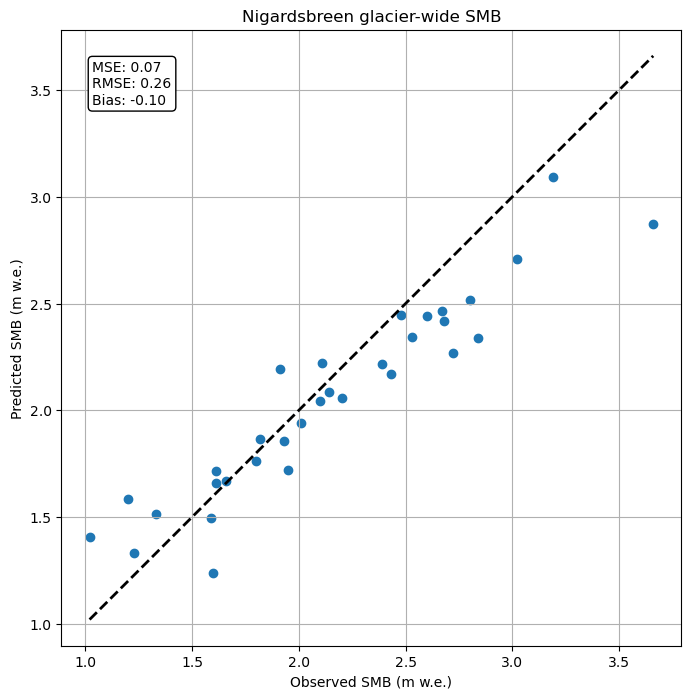

In [38]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

x = df_glacierwide_crop['B_obs']
y = df_glacierwide_crop['B_pred']

# Calculate MSE, RMSE and bias
mse = mean_squared_error(x, y)
rmse = np.sqrt(mse)
bias = np.mean(y - x)

# Create the scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(x, y, label='')

# Annotate the plot with MSE, RMSE, and bias
textstr = f'MSE: {mse:.2f}\nRMSE: {rmse:.2f}\nBias: {bias:.2f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='white'))

# Plot the line y=x to indicate the line through zero
min_val = min(min(x), min(y))
max_val = max(max(x), max(y))
plt.plot([min_val, max_val], [min_val, max_val], color='k', linestyle='--', linewidth=2)

# Set axis labels and title
plt.xlabel('Observed SMB (m w.e.)')
plt.ylabel('Predicted SMB (m w.e.)')
plt.title('Nigardsbreen glacier-wide SMB')

# Set axis to be equal
plt.axis('equal')

# Show the plot
#plt.legend()
plt.grid(True)
plt.show()
